In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
# reading names file
words = open('names.txt', 'r').read().splitlines()

In [4]:
# mappings from integers to strings and vv
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [5]:
# build dataset with train and test split
block_size = 3 # how many chars taken to predict the next char
def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [6]:
# revisted MLP
n_embd = 10 #dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g) # lookup table
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # layer with n_embd * block_size inputs into n_hidden neurons (outputs)
b1 = torch.randn(n_hidden, generator=g) # biases for each neuron in l1
W2 = torch.randn((n_hidden, vocab_size), generator=g) # layer with n_hidden inputs (from the outputs of last layer) and vocab_size neurons (outputs)
b2 = torch.randn(vocab_size, generator=g) # biases for each neuron in l2
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters))

11897


In [8]:
Xtr

tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21],
        ...,
        [15, 12,  4],
        [12,  4,  1],
        [ 4,  1, 14]])

In [12]:
C

tensor([[ 1.8440,  0.3453,  0.1953, -0.5661,  0.4527,  0.3443, -1.8090,  1.2937,
          0.8566,  1.6828],
        [-0.4254,  0.3362, -1.3770, -0.3820,  0.6596,  2.8369,  2.2826, -1.3003,
          1.0703, -0.9366],
        [ 0.5528, -0.4487, -1.0804, -0.4100,  0.1098,  0.6950,  1.5666,  0.0737,
         -0.0487,  0.7321],
        [ 0.1373,  0.7865, -0.3819,  0.8351, -1.1183, -0.4161, -0.6382,  1.1249,
         -0.8870,  0.4238],
        [-0.1833,  0.0330, -0.7241, -0.1958,  0.0107,  0.4170,  0.1350,  0.1097,
          0.0768,  0.0255],
        [-0.8707,  0.5263, -0.1781, -0.8629,  0.2441,  0.3664,  0.2807, -0.3945,
         -0.6224,  0.0207],
        [ 0.7532, -0.5172, -2.3258, -0.7503,  0.5307, -0.1141,  1.7360,  2.2596,
         -0.4344,  0.3581],
        [-0.2437,  0.5917, -0.0760, -0.0978,  0.0181,  0.9473,  0.7480,  0.6467,
         -0.0864, -0.1028],
        [-0.9858,  0.0890,  0.1122, -0.8184,  0.1134,  0.4489,  0.0606,  0.5176,
         -0.0172, -0.1952],
        [-0.5046,  

In [26]:
type(embcat[0][0].item())

float

In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(200000):

    # minibatch construct. Makes training faster / more efficient
    # splits training data into bacthes and only forward / backward passes for each batch instead on for every sample
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g) # taking 32 rows of X at a time
    # approximates gradients and takes more steps in grad. descent rather than calculating exact grad and taking less steps
    Xb, Yb = Xtr[ix], Ytr[ix] # X and Y batches
    
    # forward pass
    emb = C[Xb] # embedded training data. Makes it easier for NN to understand
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer outputs
    logits = h @ W2 + b2 # l2 output before activation. L1 output * weights2 + biases2
    loss = F.cross_entropy(logits, Yb) # output layer activation & loss
    
    # backward pass
    for p in parameters:
        p.grad = None # always set gradients to none before a backward pass so they don't keep stacking and inflate learning rate
    loss.backward()
    
    # update params
    lr = 0.1 if i < 100000 else 0.01  # switches learning rate at 100000 steps in order to be more accurate
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracks stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}') # prints loss every 10000 steps
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8760
  20000/ 200000: 2.5281
  30000/ 200000: 2.8772
  40000/ 200000: 2.0705
  50000/ 200000: 2.4949
  60000/ 200000: 2.3652
  70000/ 200000: 2.0854
  80000/ 200000: 2.2428
  90000/ 200000: 2.3158
 100000/ 200000: 2.0210
 110000/ 200000: 2.3824
 120000/ 200000: 1.9666
 130000/ 200000: 2.4264
 140000/ 200000: 2.2627
 150000/ 200000: 2.1546
 160000/ 200000: 2.1043
 170000/ 200000: 1.8062
 180000/ 200000: 2.1444
 190000/ 200000: 1.8259


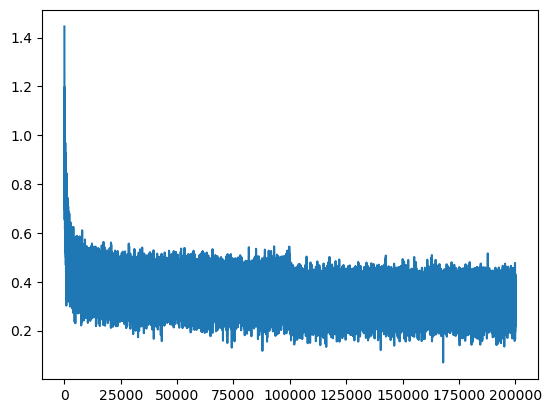

In [7]:
plt.plot(lossi) # plots loss over steps